#### In this exercise, bike share data is used from https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset to predict hourly Bike Share Count "cnt" from the available data in the dataset

In [26]:
#### IMPORTS

import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tensorflow import keras
from zipfile import ZipFile
from urllib.request import urlopen
from urllib.error import HTTPError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.exceptions import DataConversionWarning

#### TURNING OFF WARNINGS

# Turning off DataConversion warning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# Turning off the chained assignment warning
pd.options.mode.chained_assignment = None

# Fixing random number generator's seed to get reproducible results

np.random.seed(20)

In [27]:
def get_dataset():        
    
    """Checks existance of dataset and gets it if it exists at given URL

    Returns: 
        * Data frame if dataset exists online or else prints error

    """
    
    try:
        url="https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
        url = urlopen(url)
        
        # download Bike-Sharing-Dataset.zip from URL
        bike_share_zip_file=open('Bike-Sharing-Dataset.zip','wb')
        bike_share_zip_file.write(url.read())
        bike_share_zip_file.close()
        
        # Here, we store the hour.csv file in dataframe and return it
        with ZipFile("Bike-Sharing-Dataset.zip", "r") as f:
            if "hour.csv" in f.namelist():
                zip_file_object = ZipFile('Bike-Sharing-Dataset.zip') 
                # Here we make dteday as index column
                hour_csv_dataframe = pd.read_csv(zip_file_object.open('hour.csv'),parse_dates=['dteday'],index_col="dteday")
                return hour_csv_dataframe
            else:
                print("Sorry, could not find hour.csv file in zip file. Please recheck file name")
    except HTTPError:
        print("Sorry, could not connect or find the file at url", url)

#### Here we check dataset existance and read the dataset into a pandas dataframe called "data"

In [28]:
# data variable below, contains hour.csv file as dataFrame
data = get_dataset()

In [29]:
print("We have", data.shape[0], "rows and", data.shape[1], "columns in our data")

We have 17379 rows and 16 columns in our data


#### Following provides a glance at our data

In [30]:
data.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Data Analysis

#### To get some mathematical stats on our data, we describe it as follows:

In [31]:
data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


#### To graphically observe useful insights displayed by the data, I plot some charts as follows:

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Temperature'),
 Text(0.5, 1.0, 'Box Plot On Count Across Temperature')]

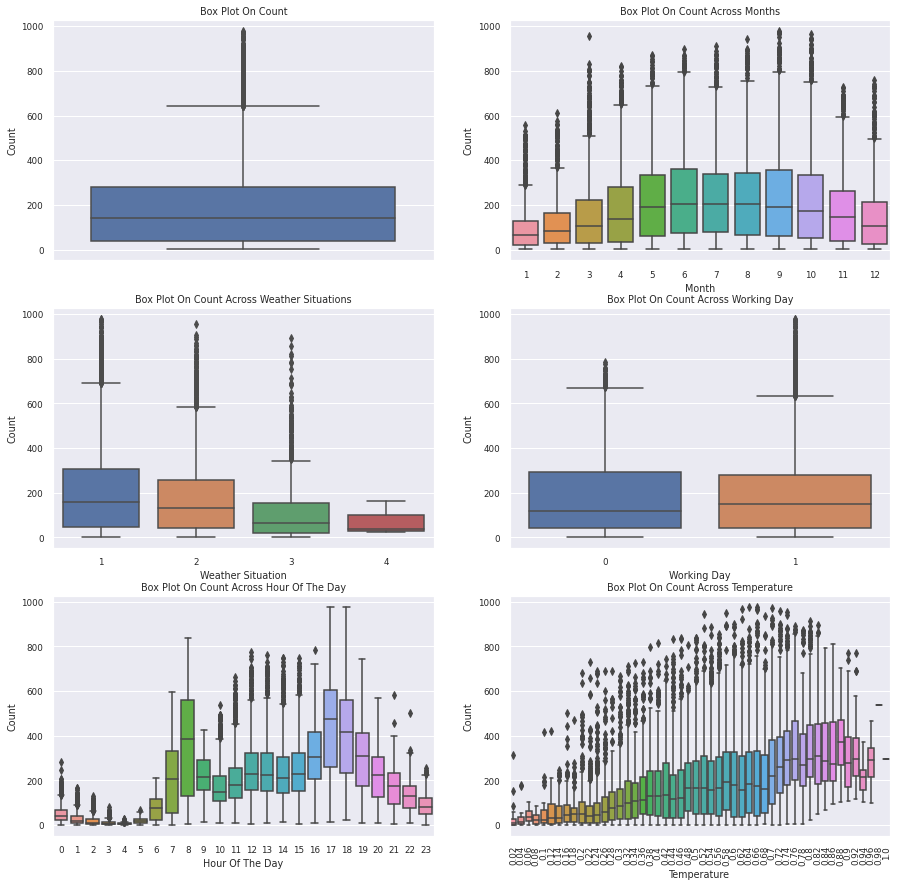

In [32]:
sns.set(font_scale=0.8)
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 15)
sns.boxplot(data=data,y="cnt",orient="v",ax=axes[0][0])
sns.boxplot(data=data,y="cnt",x="mnth",orient="v",ax=axes[0][1])
sns.boxplot(data=data,y="cnt",x="weathersit",orient="v",ax=axes[1][0])
sns.boxplot(data=data,y="cnt",x="workingday",orient="v",ax=axes[1][1])
sns.boxplot(data=data,y="cnt",x="hr",orient="v",ax=axes[2][0])
ax = sns.boxplot(data=data,y="cnt",x="temp",orient="v")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Month', ylabel='Count',title="Box Plot On Count Across Months")
axes[1][0].set(xlabel='Weather Situation', ylabel='Count',title="Box Plot On Count Across Weather Situations")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[2][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[2][1].set(xlabel='Temperature', ylabel='Count',title="Box Plot On Count Across Temperature")


## Observations:
#### 1) Plot 1 shows that most of the "cnt" values fall between 40 to 280 however there are a lot of outliers too.
#### 2) Plot 2 shows that January had the least amount of bike shares whereas in summer season bike share was high
#### 3) Plot 3 shows that when weather was clear bike share was maximum, when misty, it was less, when light snow it was lesser and when heavy rain, it was least.
#### 4) Plot 4 shows that on weekends, bike share was a bit less compared to weekdays.
#### 5) Plot 5 shows that ride share is high from 7 to 9 am then from 4 to 8pm which makes sense as 7 to 9am and 4 to 8pm are school/office going and leaving time respectively. 
#### 6) Plot 6 shows that the higher the temperature, the higher the ride share.

## Preprocessing:

#### It is obvious that "instant" column is just a count of data values and atemp is normalized temperature which we dont need for prediction since we have temp, hence we drop instant and atemp. Also, we skip column "weekday", "casual" and "registered" as they dont seem to have influence on our prediction. Casual shows users who casually use the bikes and registered shows users who are registered, we skip both.

In [33]:
data=data.drop(columns=['instant','atemp','weekday','casual','registered'])

#### Remove null values from our dataframe if they are present by dropping them

In [34]:
data=data.dropna()

In [35]:
data.head()

,season,yr,mnth,hr,holiday,workingday,weathersit,temp,hum,windspeed,cnt
dteday,,,,,,,,,,,
2011-01-01,1,0,1,0,0,0,1,0.24,0.81,0.0,16
2011-01-01,1,0,1,1,0,0,1,0.22,0.80,0.0,40
2011-01-01,1,0,1,2,0,0,1,0.22,0.80,0.0,32
2011-01-01,1,0,1,3,0,0,1,0.24,0.75,0.0,13
2011-01-01,1,0,1,4,0,0,1,0.24,0.75,0.0,1


#### I splitted 90% of data as training and 10% as test set 

In [36]:
training_set_size = int(len(data)*0.9)
test_set_size = len(data)-training_set_size
training_set,test_set = data.iloc[0:training_set_size],data.iloc[training_set_size:len(data)]
print("Length of training set is", len(training_set))    
print("Length of test set is",len(test_set))

Length of training set is 15641
Length of test set is 1738


#### Scaling continuous data optimizes machine learning model performance. I scaled temperature, humidity and windspeed to have mean 0 and standard deviation 1. This process optimizes machine learning model's performance and model converges quicker.

In [37]:
columns_to_scale = ['temp','hum','windspeed']
temp_hum_wind_transformer = StandardScaler().fit(training_set[columns_to_scale].to_numpy())
cnt_transformer = StandardScaler().fit(training_set[['cnt']])

training_set.loc[:,columns_to_scale] = temp_hum_wind_transformer.transform(training_set[columns_to_scale].to_numpy())
training_set['cnt'] = cnt_transformer.transform(training_set[['cnt']])

test_set.loc[:,columns_to_scale] = temp_hum_wind_transformer.transform(test_set[columns_to_scale].to_numpy())
test_set['cnt'] = cnt_transformer.transform(test_set[['cnt']])

#### This module is used to transform the dataset into sequence of timesteps. For example, I use '7' timesteps to predict one next output value

In [38]:
def create_data_sequence(X, y, time_steps=1):
    """ Create data sequence
    
    Arguments:
        * X: time-series data
        * y: Count "cnt" value
        * time_steps: Used to create input sequence of timesteps
    
    Returns:
        * input_sequence: Numpy array of sequences of time-series data
        * output: Numpy array of output i.e. next value for respective sequence
    
    """
    input_sequence, output = [], []
    for i in range(len(X) - time_steps):
        sequence = X.iloc[i:(i + time_steps)].values
        input_sequence.append(sequence)        
        output.append(y.iloc[i + time_steps])
    return np.array(input_sequence), np.array(output)

#### Here I define timesteps as 7 and create our training and test sets as numpy arrays since keras takes data as numpy arrays

In [39]:
training_set

,season,yr,mnth,hr,holiday,workingday,weathersit,temp,hum,windspeed,cnt
dteday,,,,,,,,,,,
2011-01-01,1,0,1,0,0,0,1,-1.405712,0.943593,-1.563900,-0.952182
2011-01-01,1,0,1,1,0,0,1,-1.508863,0.892310,-1.563900,-0.819274
2011-01-01,1,0,1,2,0,0,1,-1.508863,0.892310,-1.563900,-0.863577
2011-01-01,1,0,1,3,0,0,1,-1.405712,0.635892,-1.563900,-0.968795
2011-01-01,1,0,1,4,0,0,1,-1.405712,0.635892,-1.563900,-1.035249
...,...,...,...,...,...,...,...,...,...,...,...
2012-10-18,4,1,10,17,0,1,2,0.347855,0.071773,1.124545,3.887858
2012-10-18,4,1,10,18,0,1,2,0.244704,0.071773,1.124545,3.323002
2012-10-18,4,1,10,19,0,1,2,0.244704,0.276907,0.879769,1.800106


In [15]:
time_steps = 7

# Here training_set_sequence, test_set_sequence are input features for training and test set, as numpy arrays. 
# training_set_output and test_set_output are "cnt" values for training and test set sequences, as numpy arrays.
training_set_sequence, training_set_output = create_data_sequence(training_set, training_set.cnt, time_steps)
test_set_sequence, test_set_output = create_data_sequence(test_set, test_set.cnt, time_steps)

# We get training and test set sequences as [samples, time_steps, n_features]

print("Training data shape", training_set_sequence.shape, "Training data output shape", training_set_output.shape)
print("Test data shape", test_set_sequence.shape, "Test data output shape", test_set_output.shape)

Training data shape (15634, 7, 11) Training data output shape (15634,)
Test data shape (1731, 7, 11) Test data output shape (1731,)


In [40]:
training_set_sequence

array([[[ 1.        ,  0.        ,  1.        , ...,  0.94359324,
         -1.56390034, -0.95218165],
        [ 1.        ,  0.        ,  1.        , ...,  0.89230968,
         -1.56390034, -0.81927438],
        [ 1.        ,  0.        ,  1.        , ...,  0.89230968,
         -1.56390034, -0.8635768 ],
        ...,
        [ 1.        ,  0.        ,  1.        , ...,  0.63589188,
         -1.56390034, -1.03524869],
        [ 1.        ,  0.        ,  1.        , ...,  0.63589188,
         -0.83039034, -1.03524869],
        [ 1.        ,  0.        ,  1.        , ...,  0.89230968,
         -1.56390034, -1.02971089]],

       [[ 1.        ,  0.        ,  1.        , ...,  0.89230968,
         -1.56390034, -0.81927438],
        [ 1.        ,  0.        ,  1.        , ...,  0.89230968,
         -1.56390034, -0.8635768 ],
        [ 1.        ,  0.        ,  1.        , ...,  0.63589188,
         -1.56390034, -0.96879506],
        ...,
        [ 1.        ,  0.        ,  1.        , ...,  

## Model Training

#### Here I define LSTM model as our machine learning model for predicting bike share demand. Because LSTMS have the ability to capture the sequence in a data, hence I used LSTM. Dropout rate of 20% is used to prevent overfitting. Output is one unit as we are predicting one value of "cnt" on basis of input parameters. Since data is continuous, mean square error loss is used.

In [16]:
def machine_learning_model():
    """Defines machine learning model
    
    Returns:
        * model: LSTM model
    
    """
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=128,input_shape=(training_set_sequence.shape[1], training_set_sequence.shape[2])))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    model.summary()
    return model

#### Here I initialize our model and train it with training set, validating it with 10% of data from training set and we dont shuffle data as that would mess the sequence which is important

In [17]:
model = machine_learning_model()

history = model.fit(
    training_set_sequence,
    training_set_output, 
    epochs=5, 
    batch_size=64, 
    validation_split=0.1,
    shuffle=False,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               71680     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 71,809
Trainable params: 71,809
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
220/220 [==============================] - 5s 14ms/step - loss: 0.2360 - val_loss: 0.4223
Epoch 2/5
220/220 [==============================] - 3s 12ms/step - loss: 0.2011 - val_loss: 0.2442
Epoch 3/5
220/220 [==============================] - 3s 12ms/step - loss: 0.1143 - val_loss: 0.1773
Epoch 4/5
220/220 [==============================] - 3s 12ms/step - loss: 0.0982 -

## Results

#### Plot the loss value vs EPOCHS for the model

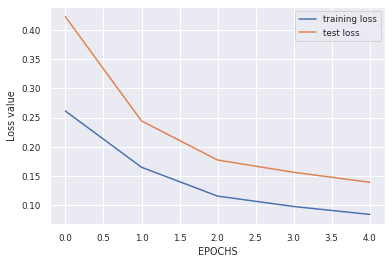

In [18]:
fig,ax = plt.subplots()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
plt.legend();

#### Predictions from trained model stored in test_set_prediction variable

In [19]:
test_set_predictions = model.predict(test_set_sequence)

#### Inverse the scaled Count "cnt" values to get original unscaled values 

In [20]:
model_predictions = cnt_transformer.inverse_transform(test_set_predictions)
actual_testset_values = cnt_transformer.inverse_transform(test_set_output)

#### Following plot shows 100 hours of Predicted Count vs Actual count in test set. It can be seen that our prediction is pretty close to the actual value.

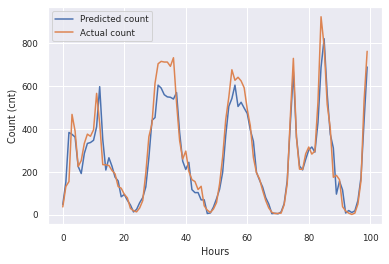

In [21]:
fig,ax = plt.subplots()
plt.plot(model_predictions[:100,], label='Predicted count')
plt.plot(actual_testset_values[:100,], label='Actual count')
ax.set_xlabel('Hours')
ax.set_ylabel('Count (cnt)')
plt.legend();
plt.show()

#### Mean absolute deviation of predicted output vs test set

In [22]:
def get_mean_absolute_deviations(predictions,actual_values):
    """ Compute the mean absolute deviations of predictions vs actual test set values
        
        Arguments:
        * predictions: Our Model's predictions
        * actual_values: Test set output
    
    """
    
    # Convert numpy arrays to data frame as pandas as mean absolute deviation function we want to use
    predictions_dataframe = pd.DataFrame(data = predictions.flatten())
    actual_test_set_values_dataframe = pd.DataFrame(data=actual_values.flatten())
        
    print("LSTM model prediction's Mean Absolute Deviation is ", predictions_dataframe.mad()[0])
    print("Test set's Mean Absolute Deviation is", actual_test_set_values_dataframe.mad()[0])

In [23]:
get_mean_absolute_deviations(model_predictions,actual_testset_values)

LSTM model prediction's Mean Absolute Deviation is  138.8947
Test set's Mean Absolute Deviation is 149.72465667521502


## Getting Predictions

#### Getting Real-time prediction on sequence of data

In [24]:
def get_prediction(input_sequence):
    """ Gets prediction of bike share count based on input sequence
    
    Arguments:
    * input_sequence: <time_steps> hours of sequence data
    
    Returns:
    * cnt_prediction: Predicted count value of bike share
    """
    
    prediction = model.predict(input_sequence)
    cnt_prediction = cnt_transformer.inverse_transform(prediction)
    return cnt_prediction


In [25]:
arbitrary_data = np.array(
     [[[ 4.        ,  1.        , 10.        , 22.        ,  0.        ,
         1.        ,  2.        ,  0.14155316,  1.04616036,  0.02427978,
         0.22737033],
       [ 4.        ,  1.        , 10.        , 23.        ,  0.        ,
         1.        ,  2.        ,  0.14155316,  1.04616036, -1.56390034,
        -0.39286357],
       [ 4.        ,  1.        , 10.        ,  0.        ,  0.        ,
         1.        ,  2.        ,  0.24470415,  1.04616036, -0.70841156,
        -0.73066954],
       [ 4.        ,  1.        , 10.        ,  1.        ,  0.        ,
         1.        ,  3.        ,  0.14155316,  1.30257816, -1.56390034,
        -0.95218165],
       [ 4.        ,  1.        , 10.        ,  2.        ,  0.        ,
         1.        ,  2.        ,  0.14155316,  1.30257816, -1.56390034,
        -0.98540846],
       [ 4.        ,  1.        , 10.        ,  3.        ,  0.        ,
         1.        ,  2.        ,  0.24470415,  1.04616036, -1.56390034,
        -1.01309748],
       [ 4.        ,  1.        , 10.        ,  4.        ,  0.        ,
         1.        ,  2.        ,  0.24470415,  1.04616036, -1.56390034,
        -1.00755968]]])
print("Predicted Bike Share Count for next hour based on last", time_steps,"hours of data is", int(get_prediction(arbitrary_data)))

Predicted Bike Share Count for next hour based on last 7 hours of data is 46
